In [1]:
%load_ext autoreload
%autoreload 2

# Sensitivity peak

The sensitivity has a strange peak at ca. $10^{-3}$. This notebook is investigating that to make sure that it really is just a result of numerical choices.

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sns.histplot = partial(sns.histplot, palette=sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1))
pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


# import umap
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from bioreaction.simulation.manager import simulate_steady_states
from bioreaction.simulation.simfuncs.basic_de import bioreaction_sim_expanded
from src.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from src.utils.misc.helper import vanilla_return
from src.utils.misc.numerical import count_monotonic_group_lengths, find_monotonic_group_idxs, is_within_range
from src.utils.misc.string_handling import string_to_tuple_list
from src.utils.misc.type_handling import flatten_listlike, get_first_elements
from src.utils.misc.string_handling import prettify_keys_for_label
from src.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from src.utils.results.analytics.timeseries import generate_analytics
from src.utils.common.testing.shared import CONFIG
from src.utils.common.setup import construct_circuit_from_cfg, prepare_config
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

CONFIG = prepare_config(CONFIG)

## Read in data

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)

In [ ]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)


In [5]:
sensitivity_mode = data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')]['sensitivity_wrt_species-6'].value_counts().index[0]

## Load circuits

In [12]:
sens_data = data[data['sensitivity_wrt_species-6'] == sensitivity_mode]
sens_circs = sens_data['circuit_name']
sens_subs = sens_data['mutation_name']
choice_data = data[data['circuit_name'].isin(sens_circs) & data['mutation_name'].isin(list(sens_subs) + ['ref_circuit'])]
choice_data = choice_data[((choice_data['sample_name'] != 'RNA_0') & (choice_data['sensitivity_wrt_species-6'] == sensitivity_mode)
                           ) | (choice_data['sample_name'] == 'RNA_0') | (choice_data['mutation_name'] == 'ref_circuit')]


<AxesSubplot: xlabel='sensitivity_wrt_species-6', ylabel='Count'>

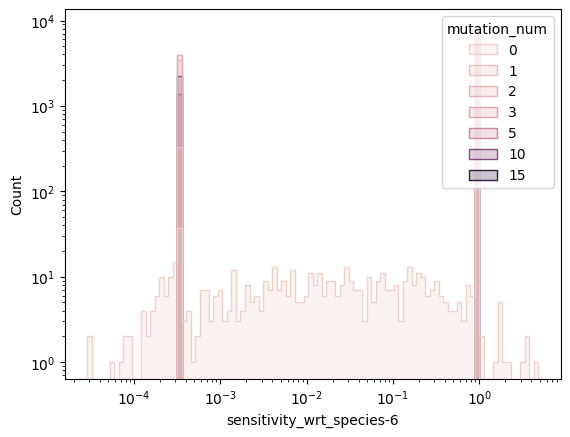

In [14]:
# choice_data[(choice_data['sample_name'] == 'RNA_1')]
# ['sensitivity_wrt_species-6'].value_counts()

sns.histplot(choice_data, x='sensitivity_wrt_species-6', hue='mutation_num', element='step', bins=100, log_scale=[True, True])

In [15]:
def load_circuit(circ_row, config):

    def symmetrical_matrix_length(flattened_length):
        return int((-1 + np.sqrt(1 + 8 * flattened_length)) / 2)

    def flatten_to_matrix(flattened_vector):
        length = symmetrical_matrix_length(len(flattened_vector))
        matrix = [[0] * length for _ in range(length)]

        index = 0
        for i in range(length):
            for j in range(i, length):
                matrix[i][j] = flattened_vector[index]
                matrix[j][i] = flattened_vector[index]
                index += 1

        return np.array(matrix)
    
    circ_path = os.path.join(og_dir, 'circuits', circ_row['name'] + '.fasta')
    interactions = {'binding_rates_association': config['molecular_params']['association_binding_rate' + '_per_molecule'],
                    'binding_rates_dissociation': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_rates_dissociation')]),
                    'eqconstants': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'eqconstants')]),
                    'energies': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'energies')]),
                    'binding_sites': flatten_to_matrix(circ_row[get_true_interaction_cols(data, 'binding_sites')])}
    circuit = construct_circuit_from_cfg({
        'data_path': circ_path,
        'interactions': interactions
    }, config)
    circuit.subname = circ_row['mutation_name']
    return circuit
    

nm = 3
circuits = []
num_circuits = 5
for i in range(num_circuits):
    ref_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['mutation_name'] == 'ref_circuit')].iloc[i]
    mut_c = choice_data[(choice_data['sample_name'] == 'RNA_1') & (choice_data['circuit_name'] == ref_c['circuit_name']) & (choice_data['mutation_name'] != 'ref_circuit')].iloc[:nm]
    circuits.append(load_circuit(circ_row=ref_c, config=CONFIG))
    for mi in range(len(mut_c)):
        circuits.append(load_circuit(circ_row=mut_c.iloc[mi], config=CONFIG))
        

forward_rates = circuits[0].qreactions.reactions.forward_rates
reverse_rates = np.asarray(
    [c.qreactions.reactions.reverse_rates for c in circuits])


t0 = 0 
t1 = 500
dt = 0.001
tmax = 5000
threshold_steady_states = 0.005

signal_onehot = np.zeros_like(circuits[0].signal.reactions_onehot) if circuits[0].use_prod_and_deg else np.zeros_like(circuits[0].signal.onehot)
sim_func = jax.jit(jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt,
                            signal=vanilla_return, signal_onehot=signal_onehot,
                            inputs=circuits[0].qreactions.reactions.inputs,
                            outputs=circuits[0].qreactions.reactions.outputs,
                            forward_rates=forward_rates,
                            solver=dfx.Tsit5(),
                            saveat=dfx.SaveAt(
                                ts=np.linspace(t0, t1, int(np.min([200, t1-t0]))))
                            )))


xla_bridge.py:backends():355: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker:  INFO
xla_bridge.py:backends():355: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter Host INFO
xla_bridge.py:backends():355: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():355: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


In [16]:

starting_states = np.asarray(
    [c.qreactions.quantities for c in circuits])
b_copynumbers, tss = simulate_steady_states(
    y0=starting_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=t1,
    threshold=threshold_steady_states, reverse_rates=reverse_rates)

b_copynumbers = np.swapaxes(b_copynumbers, 1, 2)


Done:  0:02:03.890158


In [17]:
signal_species_idx = 6

b_steady_states = b_copynumbers[:, :, -1]
b_steady_states[:, signal_species_idx] += 2 * b_copynumbers[:, signal_species_idx, 0]

b_new_copynumbers, tyy = simulate_steady_states(
    y0=b_steady_states, total_time=tmax, sim_func=sim_func,
    t0=t0, t1=tss[-1],
    threshold=threshold_steady_states,
    reverse_rates=reverse_rates)

b_new_copynumbers = np.swapaxes(b_new_copynumbers, 1, 2)

Steady states:  500.0  iterations.  22  left to steady out.  0:02:02.761240
Done:  0:04:06.971197


Text(0.5, 0.98, 'Circuit traces: reference and mutations')

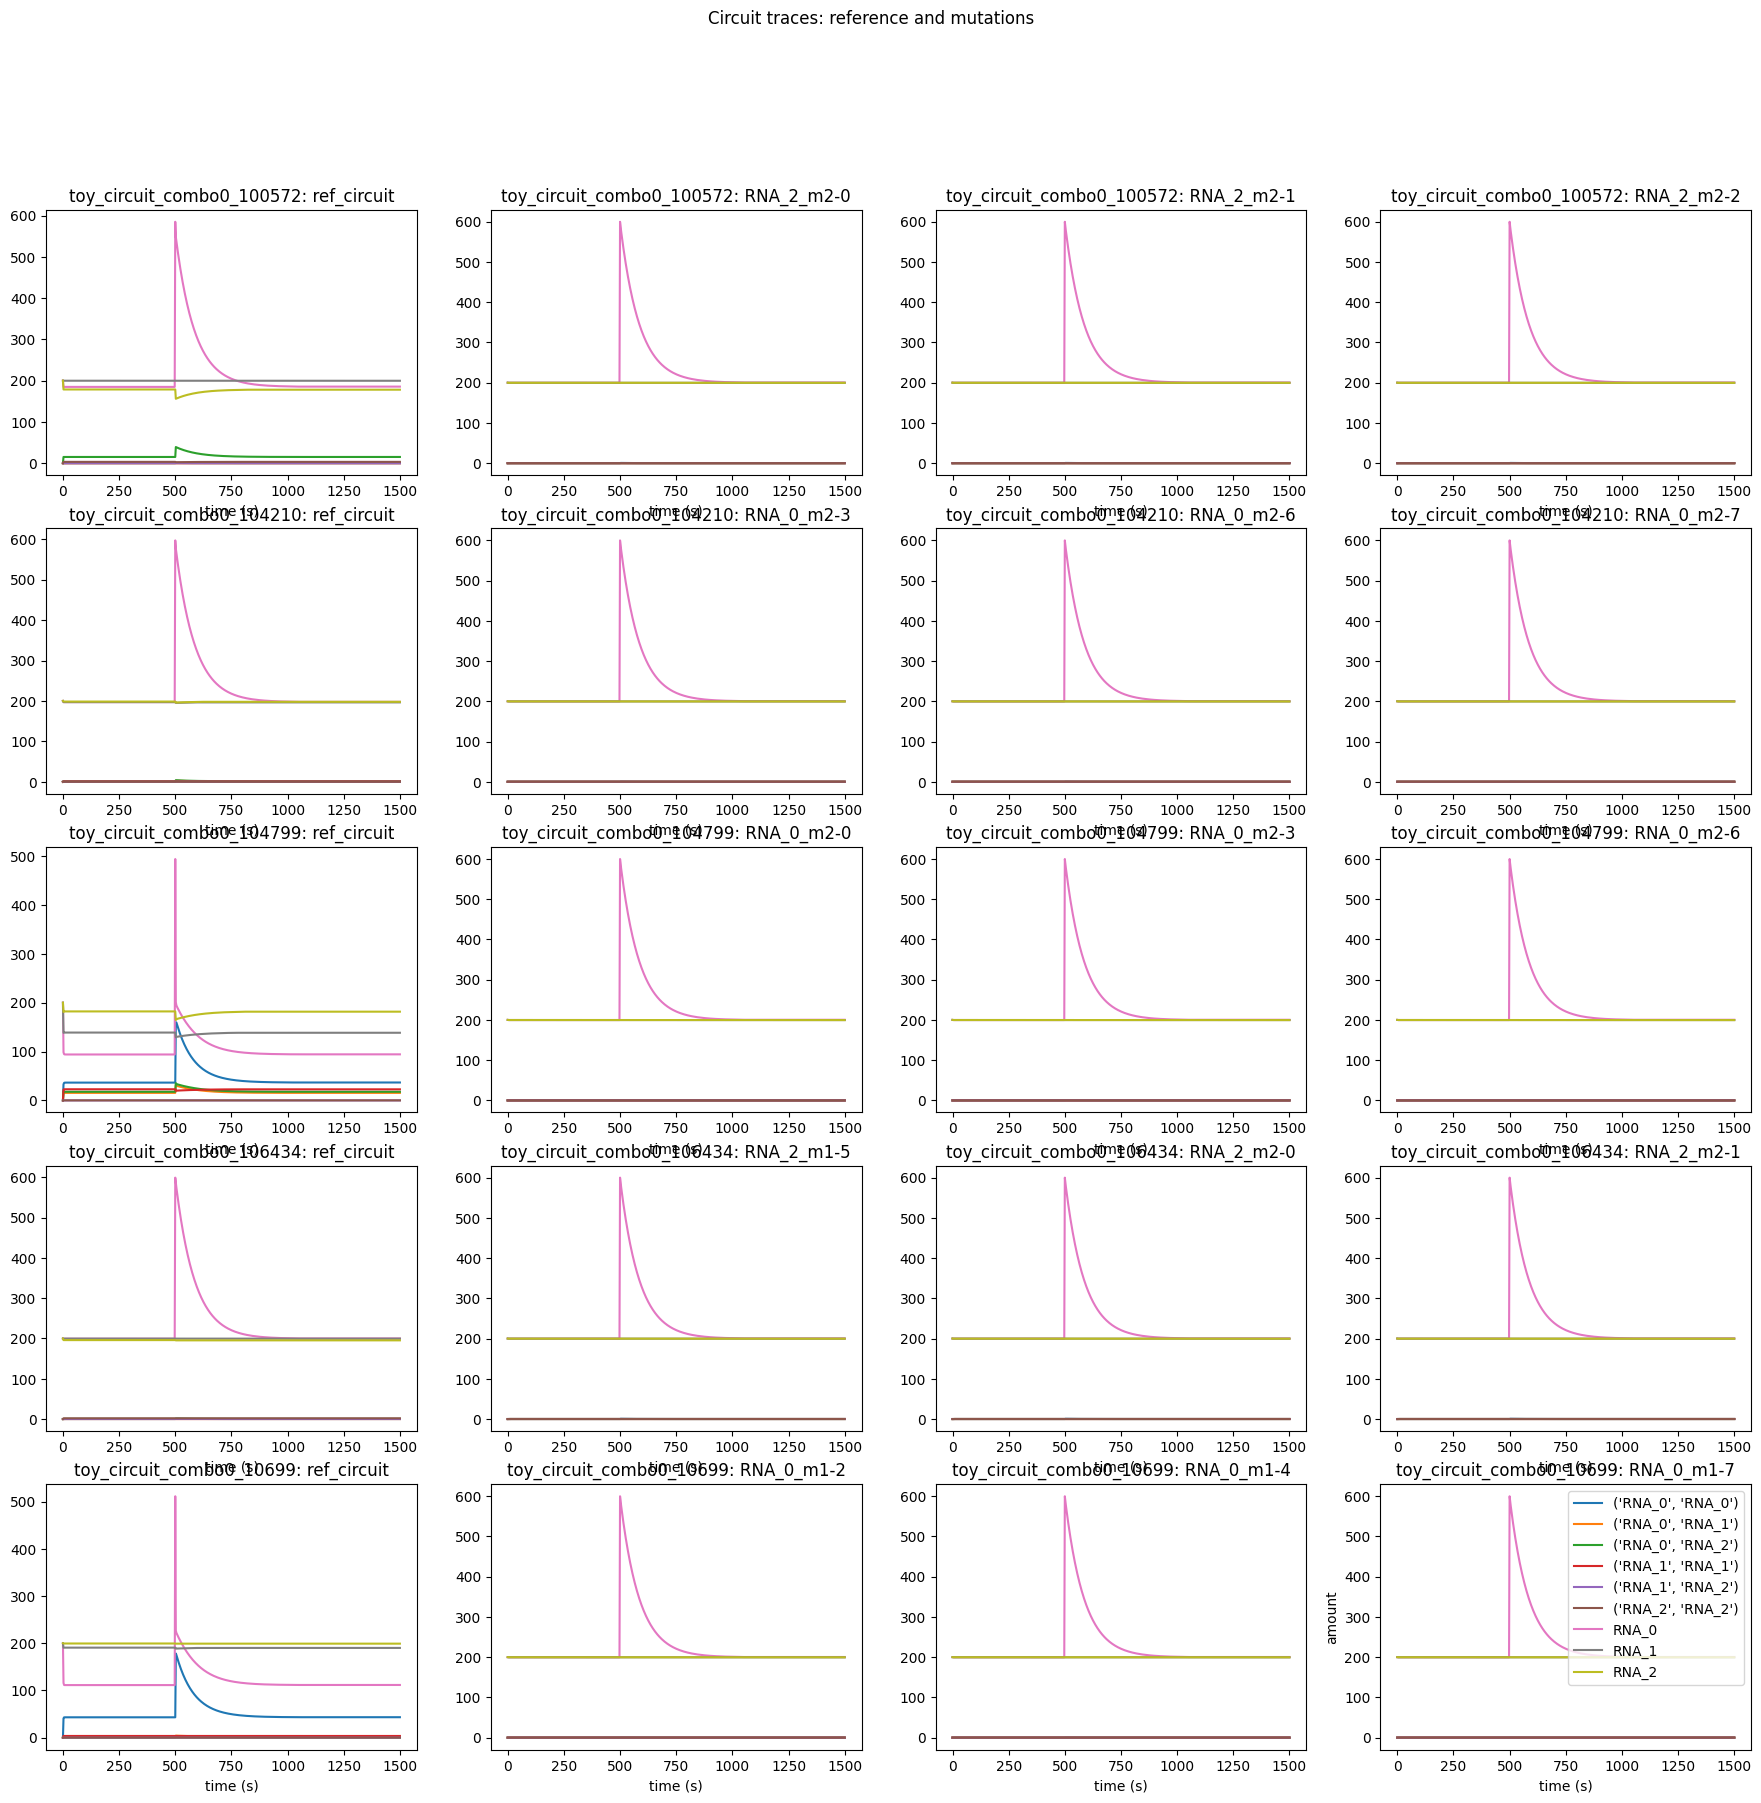

In [28]:
plt.figure(figsize=(22, 20))
for i in range(len(circuits)):
    ax = plt.subplot(num_circuits,nm+1,i+1)
    plt.plot(np.concatenate([tss, tyy + tss[-1]]), np.concatenate([b_copynumbers[i].T, b_new_copynumbers[i].T]))
    plt.title(f'{circuits[i].name}: {circuits[i].subname}')
    plt.xlabel('time (s)')
plt.legend([s.name for s in circuits[0].model.species], loc='upper right')
plt.ylabel('amount')

plt.suptitle('Circuit traces: reference and mutations')


## Analytics from trace

In [19]:

def append_nest_dicts(l: list, i1: int, d: dict) -> list:
    for i in range(i1):
        b_analytics_k = {}
        for k, v in d.items():
            b_analytics_k[k] = v[i]
        l.append(b_analytics_k)
    return l
b_analytics_l = []
        
ref_idxs = [i for i, x in enumerate([c.subname for c in circuits]) if x == "ref_circuit"]
for ref_idx, ref_idx2 in zip(ref_idxs, ref_idxs[1:] + [len(circuits)]):
    ref_circuit = circuits[ref_idx]
    analytics_func = jax.vmap(partial(
        generate_analytics, time=tyy, labels=[
            s.name for s in ref_circuit.model.species],
        signal_onehot=ref_circuit.signal.onehot, signal_time=1))
    b_analytics = analytics_func(
        data=b_new_copynumbers[ref_idx:ref_idx2])
    
    b_analytics_l = append_nest_dicts(
        b_analytics_l, ref_idx2 - ref_idx, b_analytics)

In [20]:
b_analytics = b_analytics_l[0]['sensitivity_wrt_species-6']
for b in b_analytics_l[1:]:
    b_analytics = np.concatenate([b_analytics, b['sensitivity_wrt_species-6']], axis=1)

In [24]:
np.sum((b_analytics > sensitivity_mode - 0.01) | (b_analytics < sensitivity_mode + 0.01))

180

In [ ]:
data[data['sensitivity_wrt_species-6'] == sensitivity_mode]

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,sp_distance_logm,binding_sites_groups_0-0_logm,binding_sites_groups_0-1_logm,binding_sites_groups_0-2_logm,binding_sites_groups_1-0_logm,binding_sites_groups_1-1_logm,binding_sites_groups_1-2_logm,binding_sites_groups_2-0_logm,binding_sites_groups_2-1_logm,binding_sites_groups_2-2_logm
394,toy_circuit_combo0_100572,RNA_2_m2-0,2,"[8, 9]","[19, 11]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[],[],0,...,0.000280,NaN,NaN,-inf,NaN,NaN,-inf,-inf,-inf,-inf
395,toy_circuit_combo0_100572,RNA_2_m2-0,2,"[8, 9]","[19, 11]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[],[],0,...,0.065444,NaN,NaN,-inf,NaN,NaN,-inf,-inf,-inf,-inf
397,toy_circuit_combo0_100572,RNA_2_m2-1,2,"[11, 1]","[16, 0]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[],[],0,...,0.000280,NaN,NaN,-inf,NaN,NaN,-inf,-inf,-inf,-inf
398,toy_circuit_combo0_100572,RNA_2_m2-1,2,"[11, 1]","[16, 0]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[],[],0,...,0.065444,NaN,NaN,-inf,NaN,NaN,-inf,-inf,-inf,-inf
400,toy_circuit_combo0_100572,RNA_2_m2-2,2,"[11, 9]","[17, 11]",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[],[],0,...,0.000280,NaN,NaN,-inf,NaN,NaN,-inf,-inf,-inf,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541001,toy_circuit_combo0_997201,RNA_0_m15-6,15,"[8, 4, 7, 5, 4, 1, 10, 2, 0, 3, 9, 7, 3, 9, 9]","[7, 9, 6, 11, 3, 4, 16, 12, 10, 19, 8, 15, 13,...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_997201,[],[],0,...,0.028090,-inf,-inf,-inf,-inf,NaN,NaN,-inf,NaN,NaN
541003,toy_circuit_combo0_997201,RNA_0_m15-7,15,"[11, 5, 0, 4, 5, 4, 0, 3, 10, 7, 8, 10, 10, 5, 5]","[5, 9, 10, 0, 17, 13, 4, 11, 8, 6, 1, 2, 16, 1...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_997201,[],[],0,...,-1.899783,-inf,-inf,-inf,-inf,NaN,NaN,-inf,NaN,NaN
541004,toy_circuit_combo0_997201,RNA_0_m15-7,15,"[11, 5, 0, 4, 5, 4, 0, 3, 10, 7, 8, 10, 10, 5, 5]","[5, 9, 10, 0, 17, 13, 4, 11, 8, 6, 1, 2, 16, 1...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_997201,[],[],0,...,0.028090,-inf,-inf,-inf,-inf,NaN,NaN,-inf,NaN,NaN
541009,toy_circuit_combo0_997201,RNA_0_m15-9,15,"[1, 3, 3, 6, 11, 5, 5, 6, 0, 8, 3, 4, 11, 1, 2]","[12, 11, 9, 7, 2, 13, 17, 6, 18, 1, 3, 19, 14,...",data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_997201,[],[],0,...,-1.899783,-inf,-inf,-inf,-inf,NaN,NaN,-inf,NaN,NaN


<AxesSubplot: xlabel='steady_states', ylabel='Count'>

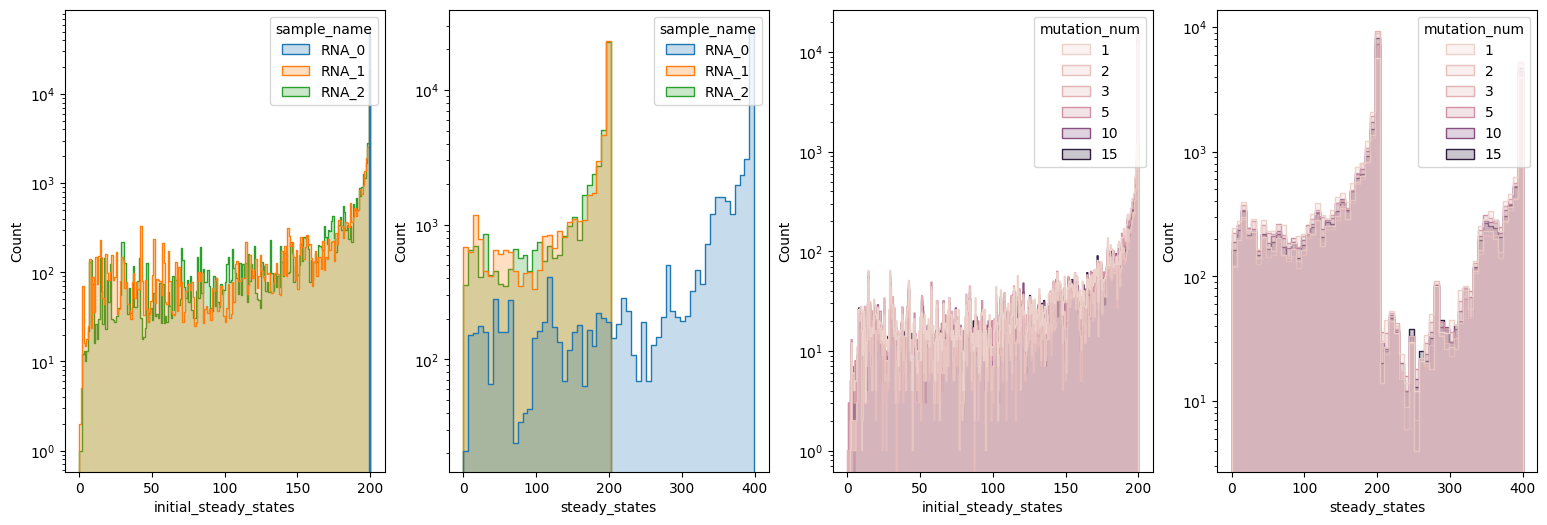

In [ ]:
plt.figure(figsize=(19,6))
ax = plt.subplot(1,4,1)
sns.histplot(choice_data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(choice_data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(choice_data, x='initial_steady_states', hue='mutation_num', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,4)
sns.histplot(choice_data, x='steady_states', hue='mutation_num', element='step', log_scale=[False, True], legend=True)



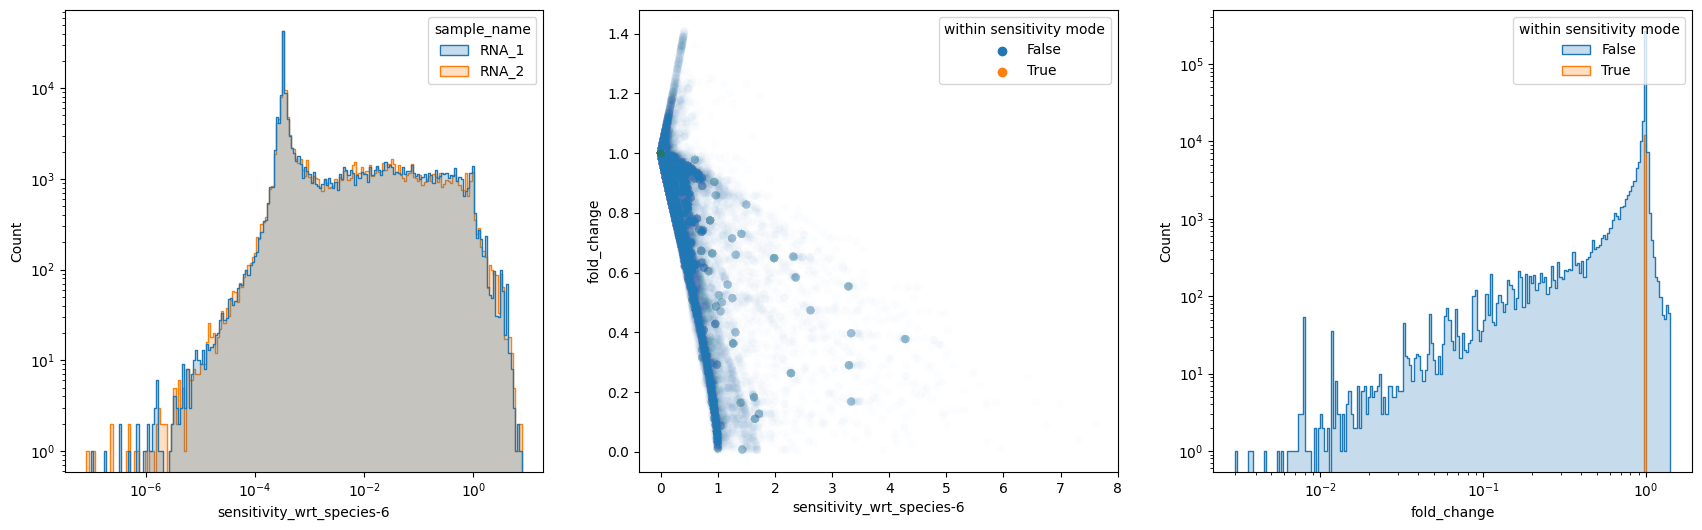

In [ ]:
plt.figure(figsize=(21,6))
ax = plt.subplot(1,3,1)
sns.histplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6', 
             hue='sample_name', element='step', bins=200, log_scale=[True, True])

ax = plt.subplot(1,3,2)
sns.scatterplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='sensitivity_wrt_species-6', 
                y='fold_change', hue=data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')]['sensitivity_wrt_species-6'] == sensitivity_mode,
                alpha=0.01)
ax.get_legend().set_title('within sensitivity mode')

ax = plt.subplot(1,3,3)
sns.histplot(data[(data['sensitivity_wrt_species-6'] > 0) & (data['sample_name'] != 'RNA_0')], x='fold_change', 
             hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=200, log_scale=[True, True])
ax.get_legend().set_title('within sensitivity mode')


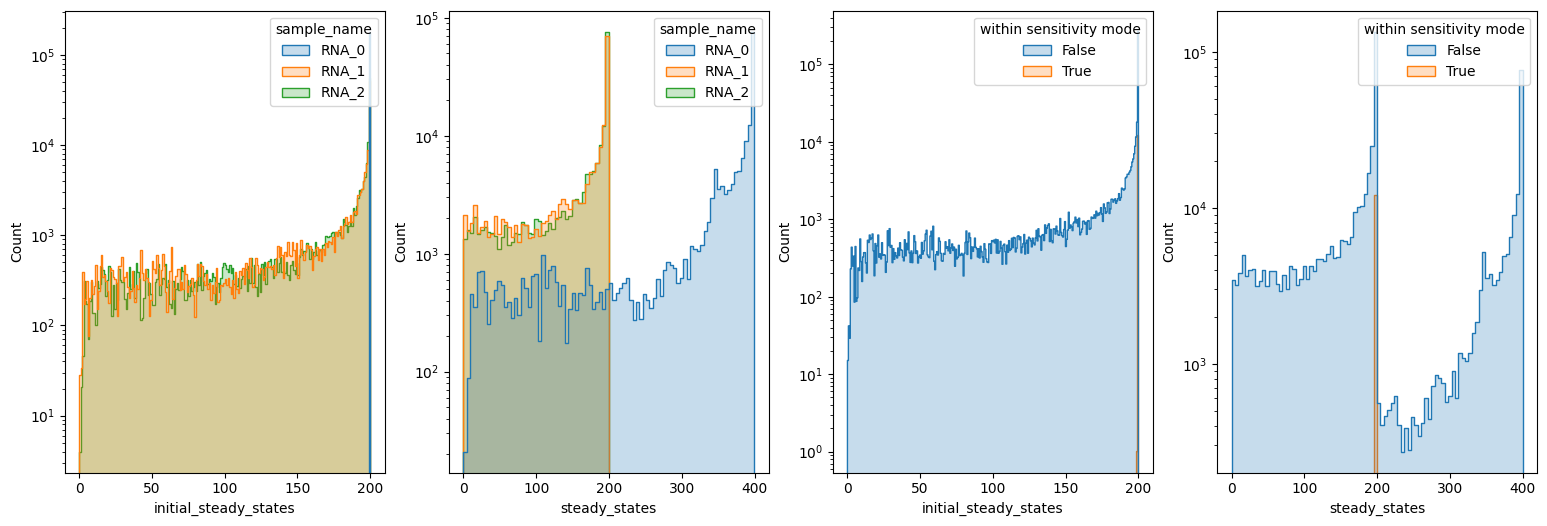

In [ ]:
plt.figure(figsize=(19,6))
ax = plt.subplot(1,4,1)
sns.histplot(data, x='initial_steady_states', hue='sample_name', element='step', bins=200, log_scale=[False, True])

ax = plt.subplot(1,4,2)
sns.histplot(data, x='steady_states', hue='sample_name', element='step', log_scale=[False, True])

ax = plt.subplot(1,4,3)
sns.histplot(x=data['initial_steady_states'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')

ax = plt.subplot(1,4,4)
sns.histplot(x=data['steady_states'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', log_scale=[False, True], legend=True)
ax.get_legend().set_title('within sensitivity mode')


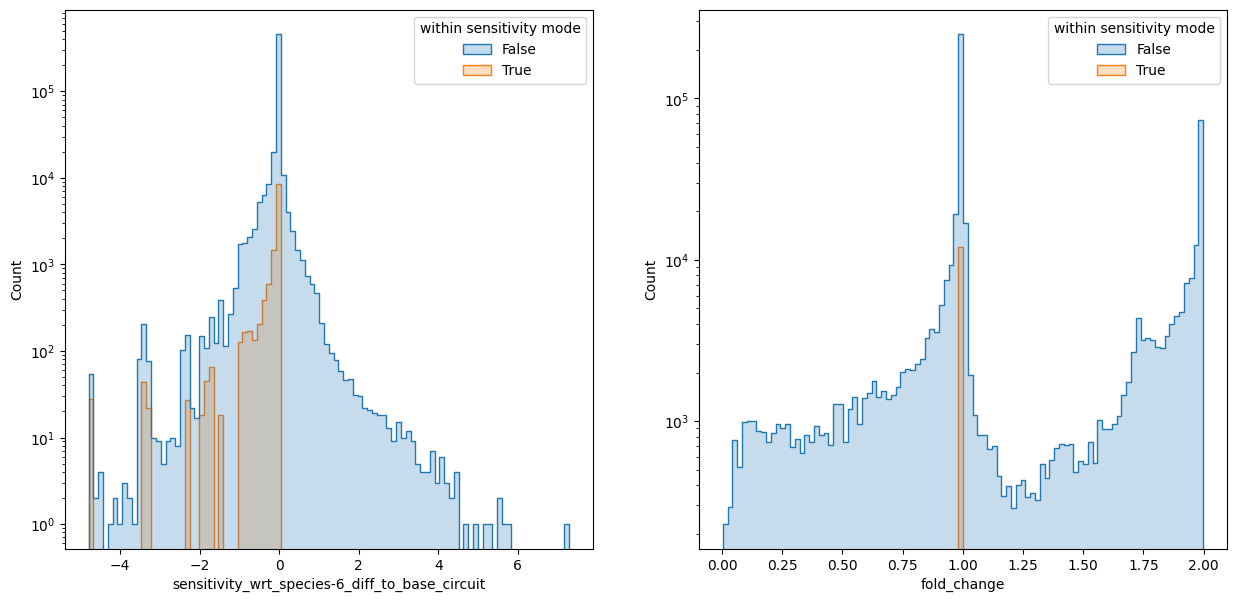

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
sns.histplot(x=data['sensitivity_wrt_species-6_diff_to_base_circuit'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')

ax = plt.subplot(1,2,2)
sns.histplot(x=data['fold_change'], hue=data['sensitivity_wrt_species-6'] == sensitivity_mode, element='step', bins=100, log_scale=[False, True])
ax.get_legend().set_title('within sensitivity mode')


In [ ]:
o2 = choice_data[choice_data['sample_name'] == 'RNA_1']['steady_states'] #.reset_index()
o1 = choice_data[choice_data['sample_name'] == 'RNA_1']['initial_steady_states'] #.reset_index()
i2 = choice_data[choice_data['sample_name'] == 'RNA_0']['steady_states'] #.reset_index()
i1 = choice_data[choice_data['sample_name'] == 'RNA_0']['initial_steady_states'] #.reset_index()

sens = ((o2 - o1) / o1).reset_index() / ((i2 - i1) / i1).reset_index()
sens

,index,0
0,1.333333,0.000629
1,1.166667,0.001873
2,1.111111,0.000623
3,1.083333,0.000091
4,1.066667,0.000542
...,...,...
51475,1.000002,-0.390293
51476,1.000002,-0.290887
51477,1.000002,-0.341942
51478,1.000002,-0.363375


In [ ]:
sum(np.abs(sens[0]) == sensitivity_mode)

0